We first import the training data:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


ATM_training = pd.read_csv('ATM_training.csv')
ATM_training.head()

In [2]:
ATM_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Shops     22000 non-null  float64
 1   ATMs      22000 non-null  int64  
 2   Downtown  22000 non-null  int64  
 3   Weekday   22000 non-null  int64  
 4   Center    22000 non-null  int64  
 5   High      22000 non-null  int64  
 6   Withdraw  22000 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 1.2 MB


In [3]:
ATM_training.describe()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
count,22000.000000,22000.000000,22000.00000,22000.000000,22000.000000,22000.000000,22000.000000
mean,7.316373,7.937455,0.70200,0.714091,0.102455,0.301591,54.652818
std,4.118692,3.673415,0.45739,0.451857,0.303252,0.458959,25.099767
min,0.800000,0.000000,0.00000,0.000000,0.000000,0.000000,11.668197
25%,1.050000,4.000000,0.00000,0.000000,0.000000,0.000000,18.500386
50%,9.890000,9.000000,1.00000,1.000000,0.000000,0.000000,68.240749
75%,10.070000,11.000000,1.00000,1.000000,0.000000,1.000000,71.345778
max,10.830000,17.000000,1.00000,1.000000,1.000000,1.000000,103.964065


In [4]:
ATM_training.isnull().sum()

Shops       0
ATMs        0
Downtown    0
Weekday     0
Center      0
High        0
Withdraw    0
dtype: int64

In [5]:
correlations = ATM_training.corr()
correlations

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,1.000000,0.872903,0.999131,0.013014,0.000004,0.001820,0.985797
ATMs,0.872903,1.000000,0.873726,0.009766,-0.003306,-0.002616,0.824030
Downtown,0.999131,0.873726,1.000000,0.012664,-0.000101,0.001782,0.983574
Weekday,0.013014,0.009766,0.012664,1.000000,-0.007153,-0.006793,-0.050470
Center,0.000004,-0.003306,-0.000101,-0.007153,1.000000,0.010521,0.088103
High,0.001820,-0.002616,0.001782,-0.006793,0.010521,1.000000,0.021275
Withdraw,0.985797,0.824030,0.983574,-0.050470,0.088103,0.021275,1.000000


There is likely multicollinearity present. Of particular note are the following pairs of extremely high correlations:
- Shops~ATMs ($\rho=0.873$)
- Shops~Downtown ($\rho=0.999$)
- ATMs~Downtown ($\rho=0.874$)

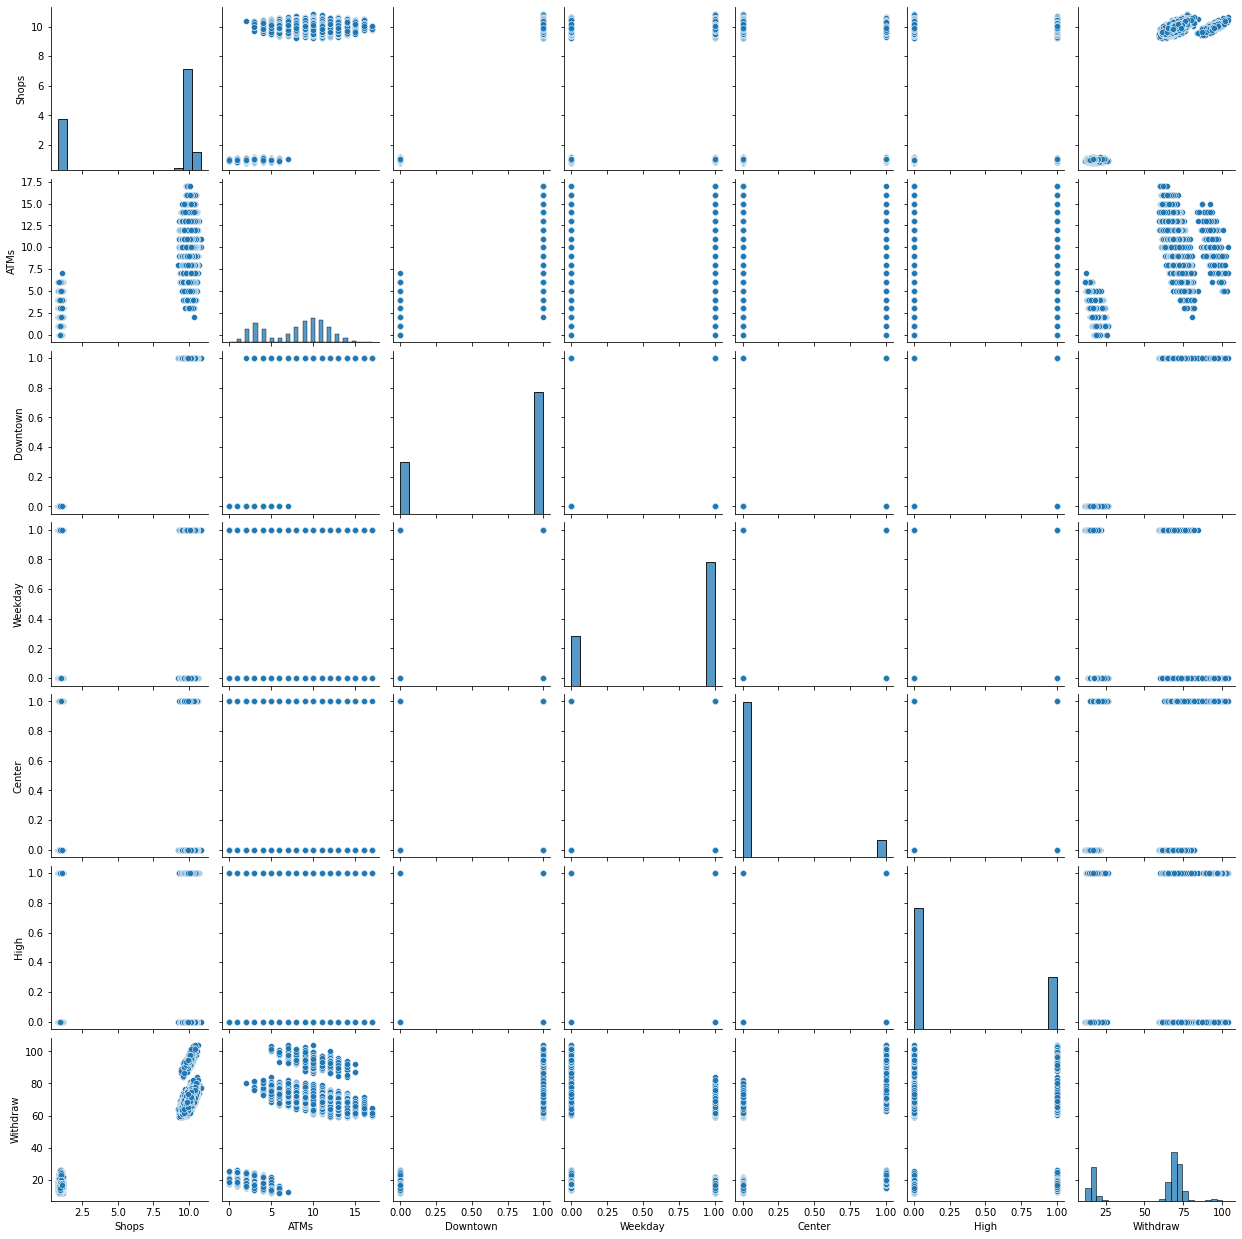

In [6]:
sns.pairplot(ATM_training)
plt.show()

Let's start with a multiple linear regression:

In [7]:
y = ATM_training["Withdraw"]
x = ATM_training.iloc[:, 0:-1]
x_with_intercept = sm.add_constant(x, prepend=True)
x_with_intercept.head()

,const,Shops,ATMs,Downtown,Weekday,Center,High
0,1.0,10.18,10,1,0,0,0
1,1.0,9.74,10,1,1,0,0
2,1.0,0.96,2,0,0,0,1
3,1.0,9.58,9,1,1,0,1
4,1.0,1.03,4,0,1,0,1


In [8]:
model_multivariate = sm.OLS(y, x_with_intercept)

result = model_multivariate.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.656e+05
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:08:45   Log-Likelihood:                -51380.
No. Observations:               22000   AIC:                         1.028e+05
Df Residuals:                   21993   BIC:                         1.028e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4284      0.111     94.198      0.0

We can obtain the predicted values for the test set:

In [63]:
ATM_test = pd.read_csv('ATM_test.csv')
ATM_test_independent = ATM_test.iloc[:, 0:-1]
ATM_test_independent_intercept = sm.add_constant(ATM_test_independent, prepend=True)
ATM_test_independent_intercept_pred=result.predict(ATM_test_independent_intercept)
ATM_test_independent_intercept_pred

0      16.554879
1      71.339688
2      66.399676
3      72.816229
4      73.646980
         ...    
145    65.719767
146    16.515216
147    71.539326
148    65.247551
149    77.130290
Length: 150, dtype: float64

We then evaluate the test error. This is substantial, but by careful evaluation of the test errors, it becomes clear that the model can predict many points very well, with the high test error coming from a few poorly-predicted points.

In [10]:
ui = ATM_test["Withdraw"]-ATM_test_independent_intercept_pred
ui
test_error = sum(i*i for i in ui)/len(ui)
test_error

7.405884449854866

However, note that this test error is not profoundly different from the training error:

In [11]:
uii = result.predict()-ATM_training["Withdraw"]
uii
train_error = sum(i*i for i in uii)/len(uii)
train_error

6.252746531168414

The R-squared suggests that the model predicts the response variable 'Withdraw' very well, although this is reason for concern. Such a high R-squared may be the result of multicollinearity, overfitting or other causes. Let's check single linear regressions for each variable:

Text(0.5, 1.0, 'Plot of Withdrawals against Shops')

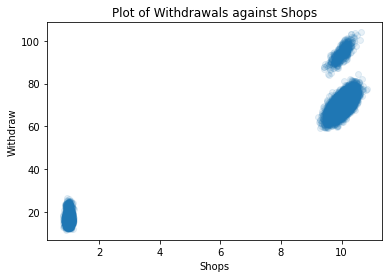

In [12]:
plt.scatter(ATM_training["Shops"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Shops")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Shops")

Text(0.5, 1.0, 'Plot of Withdrawals against ATMs')

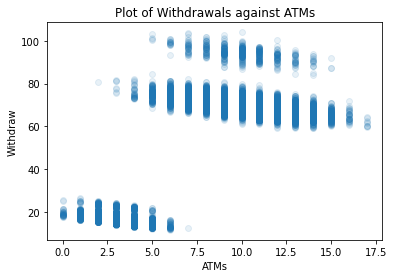

In [13]:
plt.scatter(ATM_training["ATMs"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("ATMs")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against ATMs")

Text(0.5, 1.0, 'Plot of Withdrawals against Downtown')

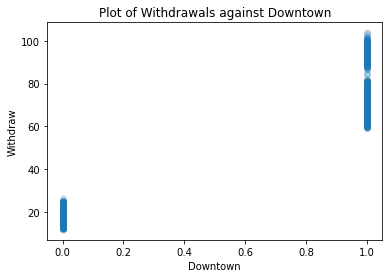

In [14]:
plt.scatter(ATM_training["Downtown"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Downtown")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Downtown")

Text(0.5, 1.0, 'Plot of Withdrawals against Weekday')

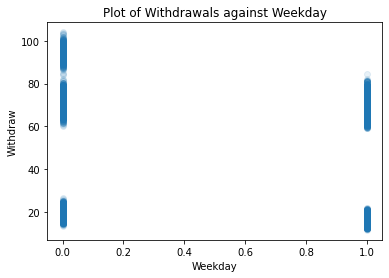

In [15]:
plt.scatter(ATM_training["Weekday"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Weekday")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Weekday")

Text(0.5, 1.0, 'Plot of Withdrawals against Center')

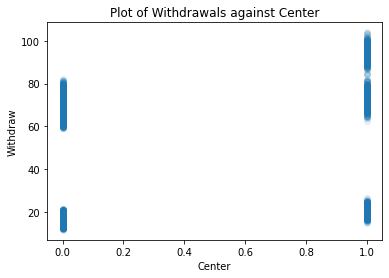

In [16]:
plt.scatter(ATM_training["Center"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Center")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Center")

Text(0.5, 1.0, 'Plot of Withdrawals against High')

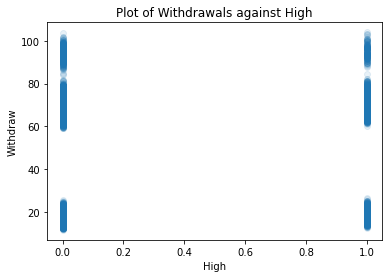

In [23]:
plt.scatter(ATM_training["High"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("High")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against High")

Clearly, a linear model with all predictors is not suitable. There is significant data clustering among all variables. Instead, we can attempt to remove certain variables to minimise multicollinearity:

In [166]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(x):

    vif = pd.DataFrame()
    vif["variables"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

    return(vif)

calc_vif(x)

,variables,VIF
0,Shops,526.111070
1,ATMs,22.334925
2,Downtown,405.094529
3,Weekday,3.669043
4,Center,3.746856
5,High,1.417255
6,WeekdayCenter,3.750830


Generally speaking, a Variance Inflation Factor (VIF) of above 10 indicates the likely presence of multicollinearity. Clearly, the variables 'Shops' and 'Downtown' have a particularly high VIF, meaning that they can largely be predicted by the other predictors in the dataset. The variable 'ATMs' has a relatively high VIF in the presence of 'Shops' and 'Downtown'. However, if we remove 'Shops' and 'Downtown', we see that the VIF on 'ATMs' drops to an acceptable level:

In [25]:
v=[1,3,4,5]
x = ATM_training.iloc[:, v]
calc_vif(x)

,variables,VIF
0,ATMs,2.653734
1,Weekday,2.509087
2,Center,1.098688
3,High,1.358037


Therefore, we run another linear model but with only 'ATMs', 'Weekday', 'Center' and 'High' as predictors:

In [35]:
y = ATM_training["Withdraw"]
v=[1,3,4,5]
x = ATM_training.iloc[:, v]

x_with_intercept = sm.add_constant(x, prepend=True)
x_with_intercept.head()

model_multivariate = sm.OLS(y, x_with_intercept)

result1 = model_multivariate.fit()

print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                 1.230e+04
Date:                Sun, 30 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:40:51   Log-Likelihood:                -89196.
No. Observations:               22000   AIC:                         1.784e+05
Df Residuals:                   21995   BIC:                         1.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0724      0.277     39.965      0.0

The R-squared is much more reasonable, and the t-statistics are not suspiciously high (although they are still quite high for a typical linear regression). We then evaluate the test error:

In [37]:
ATM_test = pd.read_csv('ATM_test.csv')
v=[1,3,4,5]
ATM_test_independent1 = ATM_test.iloc[:, v]
ATM_test_independent_intercept1 = sm.add_constant(ATM_test_independent1, prepend=True)
ATM_test_independent_intercept_pred1=result1.predict(ATM_test_independent_intercept1)
ATM_test_independent_intercept_pred1

0      33.619286
1      52.959358
2      81.142998
3      75.506270
4      47.322630
         ...    
145    78.713110
146    13.502263
147    54.167531
148    58.596086
149    86.177616
Length: 150, dtype: float64

In [38]:
ui = ATM_test["Withdraw"]-ATM_test_independent_intercept_pred1
ui
test_error1 = sum(i*i for i in ui)/len(ui)
test_error1

194.74779533631283

Hence this new model has far worse predictive power, despite not suffering from multicollinearity.

Let's try interaction terms. We can run scatterplots of the interaction terms against the response "Withdraw", with some interesting results. Many of the interactions did not display any apparent trend, but the following five did:

Text(0.5, 1.0, 'Plot of Withdrawals against Shops*Downtown')

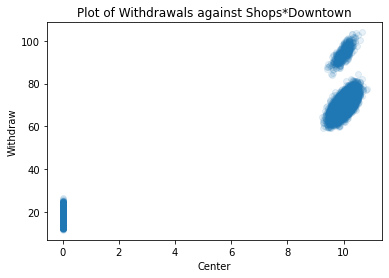

In [205]:
plt.scatter(ATM_training["Shops"]*ATM_training["Downtown"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Shops*Downtown")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Shops*Downtown")

Above, note that all the points with a low withdrawal have "Downtown=0".

Text(0.5, 1.0, 'Plot of Withdrawals against Weekday*Center')

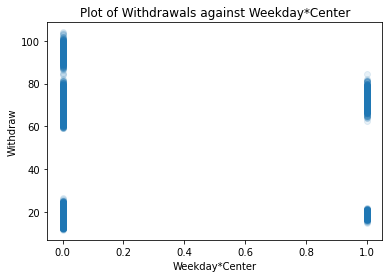

In [206]:
plt.scatter(ATM_training["Weekday"]*ATM_training["Center"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Weekday*Center")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Weekday*Center")

Above, note that the points with a high withdrawal (above approximately 82 or so) have "Weekday * Center=0". This is because "Weekday=0" for all the points with a high withdrawal.

Text(0.5, 1.0, 'Plot of Withdrawals against Weekday*High')

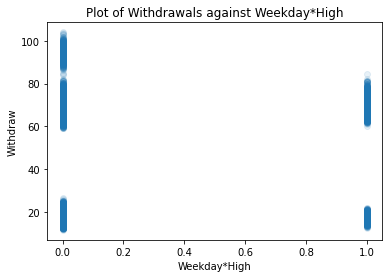

In [207]:
plt.scatter(ATM_training["Weekday"]*ATM_training["High"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Weekday*High")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Weekday*High")

Above, note that the points with a high withdrawal (above approximately 82 or so) have "Weekday * High=0". This is very similar to the plot of "Weekday * Center". This is because "Weekday=0" for all the points with a high withdrawal.

Text(0.5, 1.0, 'Plot of Withdrawals against Weekday*Downtown')

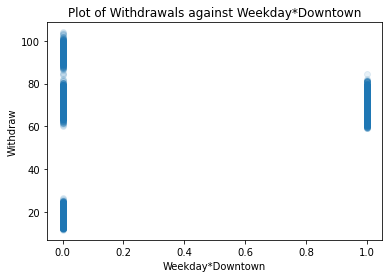

In [208]:
plt.scatter(ATM_training["Weekday"]*ATM_training["Downtown"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Weekday*Downtown")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Weekday*Downtown")

Above, note that the points with a high withdrawal (above approximately 82 or so) have "Weekday * Downtown=0". This is because "Weekday=0" for all the points with a high withdrawal.

Also note that the points with a low withdrawal have "Weekday * Downtown=0" as well. 

Text(0.5, 1.0, 'Plot of Withdrawals against Downtown*Center')

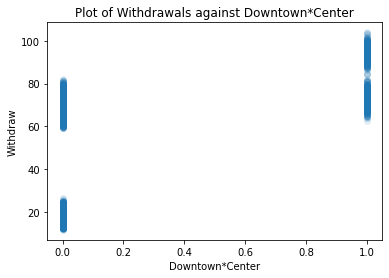

In [209]:
plt.scatter(ATM_training["Downtown"]*ATM_training["Center"], ATM_training["Withdraw"], alpha = 0.1)
plt.xlabel("Downtown*Center")
plt.ylabel("Withdraw")
plt.title("Plot of Withdrawals against Downtown*Center")

Above, note that the points with a high withdrawal (above approximately 82 or so) have "Downtown * Center=1". This is because "Downtown=1" and "Center=1" for all the points with a high withdrawal.

Also note that the points with a low withdrawal have "Downtown * Center=0".

Hence we believe the following interaction terms tell us something about the upper cluster of withdrawals:

    > "Shops * Downtown"
    > "Weekday * Center"
    > "Weekday * High" 
    > "Weekday * Downtown"
    > "Downtown * Center"
    
Let's generate these interaction terms and add them to our dataset:

In [211]:
ShopsDowntown = ATM_training["Shops"]*ATM_training["Downtown"]
WeekdayCenter = ATM_training["Weekday"]*ATM_training["Center"]
WeekdayHigh = ATM_training["Weekday"]*ATM_training["High"]
WeekdayDowntown = ATM_training["Weekday"]*ATM_training["Downtown"]
DowntownCenter = ATM_training["Downtown"]*ATM_training["Center"]


ATM_training["ShopsDowntown"] = ShopsDowntown
ATM_training["WeekdayCenter"] = WeekdayCenter 
ATM_training["WeekdayHigh"] = WeekdayHigh
ATM_training["WeekdayDowntown"] = WeekdayDowntown
ATM_training["DowntownCenter"] = DowntownCenter

ShopsDowntown = ATM_test["Shops"]*ATM_test["Downtown"]
WeekdayCenter = ATM_test["Weekday"]*ATM_test["Center"]
WeekdayHigh = ATM_test["Weekday"]*ATM_test["High"]
WeekdayDowntown = ATM_test["Weekday"]*ATM_test["Downtown"]
DowntownCenter = ATM_test["Downtown"]*ATM_test["Center"]


ATM_test["ShopsDowntown"] = ShopsDowntown
ATM_test["WeekdayCenter"] = WeekdayCenter 
ATM_test["WeekdayHigh"] = WeekdayHigh
ATM_test["WeekdayDowntown"] = WeekdayDowntown
ATM_test["DowntownCenter"] = DowntownCenter

ATM_training.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw,ShopsDowntown,WeekdayCenter,WeekdayHigh,WeekdayDowntown,DowntownCenter
0,10.18,10,1,0,0,0,72.750556,10.18,0,0,0,0
1,9.74,10,1,1,0,0,66.720482,9.74,0,0,1,0
2,0.96,2,0,0,0,1,19.189516,0.00,0,0,0,0
3,9.58,9,1,1,0,1,67.388669,9.58,0,1,1,0
4,1.03,4,0,1,0,1,15.813127,0.00,0,1,0,0


We test the different interaction terms. The one with the lowest root mean squared error is included below:

In [212]:
y = ATM_training["Withdraw"]
v=[0,1,2,3,4,5,8]
x = ATM_training.iloc[:, v]

x_with_intercept2 = sm.add_constant(x, prepend=True)
x_with_intercept2.head()

model_multivariate = sm.OLS(y, x_with_intercept2)

result2 = model_multivariate.fit()

print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 8.354e+05
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:45:58   Log-Likelihood:                -40663.
No. Observations:               22000   AIC:                         8.134e+04
Df Residuals:                   21992   BIC:                         8.141e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.2959      0.068    136.147

In [213]:
x = ATM_training.iloc[:, v]
calc_vif(x)

,variables,VIF
0,Shops,526.111070
1,ATMs,22.334925
2,Downtown,405.094529
3,Weekday,3.669043
4,Center,3.746856
5,High,1.417255
6,WeekdayCenter,3.750830


In [214]:
ATM_test_independent2 = ATM_test.iloc[:, v]
ATM_test_independent2.head()
ATM_test_independent_intercept2 = sm.add_constant(ATM_test_independent2, prepend=True)
ATM_test_independent_intercept2
ATM_test_independent_intercept_pred2=result2.predict(ATM_test_independent_intercept2)
ATM_test_independent_intercept_pred2

0      15.472670
1      71.753106
2      66.844272
3      73.268237
4      74.057479
         ...    
145    64.653829
146    16.906855
147    71.971274
148    65.654372
149    86.148791
Length: 150, dtype: float64

In [215]:
ui = ATM_test["Withdraw"]-ATM_test_independent_intercept_pred2
ui
test_error1 = sum(i*i for i in ui)/len(ui)
test_error1

2.2655475731936976

However, while the MSE has improved somewhat, multicollinearity is still likely. We should test for this using the VIF:

In [216]:
x = ATM_training.iloc[:, v]
calc_vif(x)

,variables,VIF
0,Shops,526.111070
1,ATMs,22.334925
2,Downtown,405.094529
3,Weekday,3.669043
4,Center,3.746856
5,High,1.417255
6,WeekdayCenter,3.750830


A VIF of above roughly 10 indicates a variable has strong multicollinearity, causing an increase in the variance of estimates because the estimation procedure is less efficient. Here, "Shops" and "Downtown" suffer from severe multicollinearity, while "ATMs" suffers from moderate multicollinearity.

If we remove any of the variables to eliminate multicollinearity, the test MSE increases to approximately 6 or 7 (only slightly less, or around the same as if the interaction terms were excluded). Therefore, while attempting to include interaction terms is a sensible idea, it did not yield fruitful results.

We try testing the neural networks method, first without any interaction terms:

In [1]:
np.random.seed(1000) #Fix random seed
#Import data
ATM_training = pd.read_csv('ATM_training.csv')
ATM_test = pd.read_csv('ATM_test.csv')

v=[0,1,2,3,4,5]
X_train = ATM_training.iloc[:,v]; y_train = ATM_training.iloc[:,6]
X_test = ATM_test.iloc[:,v]; y_test = ATM_test.iloc[:,6]

#Standardise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from keras.models import Sequential
from keras.layers import Dense

# Now buid the neural net model
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu')) # the first hidden layer has 6 units, input has 6 units
# add another hidden layer with 6 units
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='linear')) # the output layer has 1 unit with the linear activation

# Compile model
model.compile(loss='MSE', optimizer='adam')
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=100)
# Evaluate the model
MSE_nn = model.evaluate(X_test, y_test)
print('\n Root of MSE on the test data for neural net:', np.sqrt(MSE_nn))

NameError: name 'np' is not defined

There is a substantial reduction in test MSE when a neural network is used (note that the final line actually reports the square root of the MSE because this is reported in terms of the scale of the data, although the assignment requests that we use the MSE). However, we might be able to obtain a better result using the interaction terms (although this makes the model harder to interpret and increases the demand for computing power).

In [196]:
np.random.seed(1000) #Fix random seed
#Import data
ATM_training = pd.read_csv('ATM_training.csv')
ATM_test = pd.read_csv('ATM_test.csv')

#Generate additional interaction terms of interest
ShopsDowntown = ATM_training["Shops"]*ATM_training["Downtown"]
WeekdayCenter = ATM_training["Weekday"]*ATM_training["Center"]
WeekdayHigh = ATM_training["Weekday"]*ATM_training["High"]
WeekdayDowntown = ATM_training["Weekday"]*ATM_training["Downtown"]
DowntownCenter = ATM_training["Downtown"]*ATM_training["Center"]

ATM_training["ShopsDowntown"] = ShopsDowntown
ATM_training["WeekdayCenter"] = WeekdayCenter 
ATM_training["WeekdayHigh"] = WeekdayHigh
ATM_training["WeekdayDowntown"] = WeekdayDowntown
ATM_training["DowntownCenter"] = DowntownCenter

ShopsDowntown = ATM_test["Shops"]*ATM_test["Downtown"]
WeekdayCenter = ATM_test["Weekday"]*ATM_test["Center"]
WeekdayHigh = ATM_test["Weekday"]*ATM_test["High"]
WeekdayDowntown = ATM_test["Weekday"]*ATM_test["Downtown"]
DowntownCenter = ATM_test["Downtown"]*ATM_test["Center"]

ATM_test["ShopsDowntown"] = ShopsDowntown
ATM_test["WeekdayCenter"] = WeekdayCenter 
ATM_test["WeekdayHigh"] = WeekdayHigh
ATM_test["WeekdayDowntown"] = WeekdayDowntown
ATM_test["DowntownCenter"] = DowntownCenter

v=[0,1,2,3,4,5,7,8,9,10,11]
X_train = ATM_training.iloc[:,v]; y_train = ATM_training.iloc[:,6]
X_test = ATM_test.iloc[:,v]; y_test = ATM_test.iloc[:,6]

#Standardise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from keras.models import Sequential
from keras.layers import Dense

# Now buid the neural net model
model = Sequential()
model.add(Dense(11, input_dim=11, activation='relu')) # the first hidden layer has 11 units, input has 11 units
# add another hidden layer with 11 units
model.add(Dense(11, activation='relu'))
model.add(Dense(1, activation='linear')) # the output layer has 1 unit with the linear activation

# Compile model
model.compile(loss='MSE', optimizer='adam')
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10)
# Evaluate the model
MSE_nn = model.evaluate(X_test, y_test)
print('\n Root of MSE on the test data for neural net:', np.sqrt(MSE_nn))

Epoch 1/100
2200/2200 [==============================] - 10s 4ms/step - loss: 488.4091
Epoch 2/100
2200/2200 [==============================] - 12s 5ms/step - loss: 0.7176
Epoch 3/100
2200/2200 [==============================] - 16s 7ms/step - loss: 0.4160
Epoch 4/100
2200/2200 [==============================] - 12s 6ms/step - loss: 0.3486
Epoch 5/100
2200/2200 [==============================] - 13s 6ms/step - loss: 0.3299
Epoch 6/100
2200/2200 [==============================] - 10s 4ms/step - loss: 0.3223
Epoch 7/100
2200/2200 [==============================] - 11s 5ms/step - loss: 0.3220
Epoch 8/100
2200/2200 [==============================] - 9s 4ms/step - loss: 0.3197
Epoch 9/100
2200/2200 [==============================] - 8s 4ms/step - loss: 0.3175
Epoch 10/100
2200/2200 [==============================] - 6s 3ms/step - loss: 0.3120
Epoch 11/100
2200/2200 [==============================] - 7s 3ms/step - loss: 0.3091
Epoch 12/100
2200/2200 [==============================] - 6s 3ms/

As seen above, there isn't really a substantial improvement when the interaction terms are included (the MSE from the model without interaction terms is actually slightly less than the MSE from the model with interaction terms). Overall, the MSE's are comparable, whether or not the interaction terms are included. This is expected because the neural network model "learns" from the data, and there is no new "knowledge" provided by including interaction terms that are simply functions of the simpler covariates.

Additionally, including the interactions makes the model less efficient computationally. 

We also find that by adding an additional hidden layer, the test MSE decreases substantially. The test MSE was approximately 1.2 prior to the inclusion of the additional hidden layer. This hidden layer helps the model find the best predictors as functions of the covariates (although we do not know what these functions are because the deep learning/neural network model has low interpretability).